이 코드는 2021년 12월 14일에 tensorflow 2.7 버전으로 마지막으로 테스트 되었습니다.  

이 코드는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'의 seq2seq 튜토리얼입니다.

링크 : https://wikidocs.net/24996

# **14. RNN을 이용한 인코더-디코더**
앞서 RNN의 **다 대 일(many-to-one)** 구조로 `텍스트 분류`를 풀 수 있었고, **다 대 다(many-to-many)** 구조로는 `개체명 인식`이나 `품사 태깅`과 같은 문제를 풀 수 있었습니다. 이번에 살펴볼 RNN의 구조는 앞에서 살펴본 구조와는 다소 차이가 있는데, **하나의 RNN을 인코더. 또 다른 하나의 RNN을 디코더** 라는 모듈로 명명하고 두 개의 RNN을 연결해서 사용하는 인코더-디코더 구조입니다.

이러한 인코더-디코더 구조는 주로 **입력 문장과 출력 문장의 길이가 다를 경우** 에 사용하는데, 대표적인 분야가 **번역기** 나 **텍스트 요약** 과 같은 경우가 있습니다. 영어 문장을 한국어 문장으로 번역한다고 하였을 때, 입력 문장인 영어 문장과 번역된 결과인 한국어 문장의 길이는 똑같을 필요가 없습니다. 텍스트 요약의 경우에는 출력 문장이 요약된 문장이므로 입력 문장보다는 당연히 길이가 짧을 것입니다.

이번 챕터에서는 RNN의 인코더와 디코더가 각각 어떤 방식으로 동작하여 입력 문장으로부터 출력 문장을 연산해내는지 번역기 구현 프로젝트를 통해서 학습합니다. 그리고 번역이라는 섬세한 자연어 처리 태스크를 기계적으로 평가할 수 있는 방법인 BLEU(Bilingual Evaluation Understudy Score)라는 평가 방법에 대해서 설명합니다.

## **14-01 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)**

이번 실습은 **케라스 함수형 API** 에 대한 이해가 필요합니다. 함수형 API(functional API, https://wikidocs.net/38861 )에 대해서 우선 숙지 후 실습을 진행해주세요.

**시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq)** 는 **입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력** 하는 다양한 분야에서 사용되는 모델입니다. 예를 들어 **챗봇(Chatbot)** 과 **기계 번역(Machine Translation)** 이 그러한 대표적인 예인데, 입력 시퀀스와 출력 시퀀스를 각각 질문과 대답으로 구성하면 챗봇으로 만들 수 있고, 입력 시퀀스와 출력 시퀀스를 각각 입력 문장과 번역 문장으로 만들면 번역기로 만들 수 있습니다. 그 외에도 **내용 요약(Text Summarization)** , **STT(Speech to Text)** 등에서 쓰일 수 있습니다.

여기서는 기계 번역을 예제로 시퀀스-투-시퀀스를 설명합니다. 줄여서 seq2seq이라는 이름으로 명명하겠습니다.

---
### **1. 시퀀스-투-시퀀스(Sequence-to-Sequence)**
**seq2seq** 는 번역기에서 대표적으로 사용되는 모델입니다. 앞으로의 설명 방식은 내부가 보이지 않는 커다란 블랙 박스에서 점차적으로 확대해가는 방식으로 설명합니다. 여기서 설명하는 내용의 대부분은 RNN 챕터에서 언급한 내용들로 단지 RNN을 어떻게 조립했느냐에 따라서 seq2seq라는 구조가 만들어집니다.

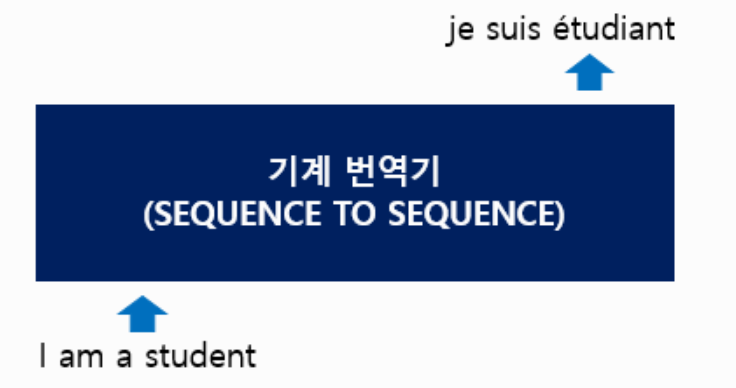

위의 그림은 seq2seq 모델로 만들어진 번역기가 'I am a student'라는 영어 문장을 입력받아서, 'je suis étudiant'라는 프랑스 문장을 출력하는 모습을 보여줍니다. 그렇다면, seq2seq 모델 내부의 모습은 어떻게 구성되었을까요?

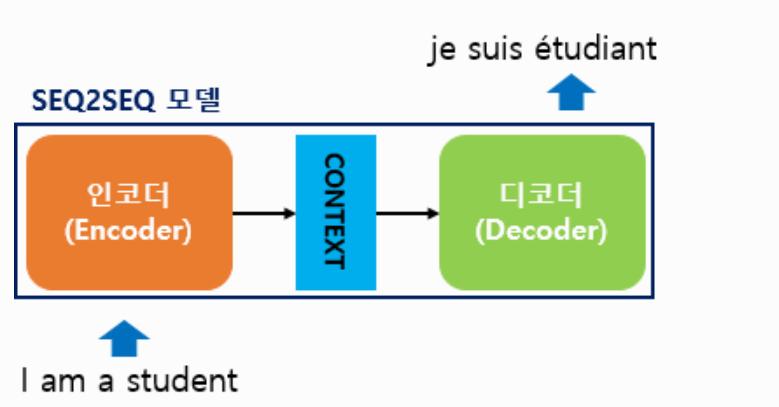

seq2seq는 크게 인코더와 디코더라는 두 개의 모듈로 구성됩니다. 인코더는 입력 문장의 모든 단어들을 순차적으로 입력받은 뒤에 마지막에 이 모든 단어 정보들을 압축해서 하나의 벡터로 만드는데, 이를 **컨텍스트 벡터(context vector)** 라고 합니다. 입력 문장의 정보가 하나의 컨텍스트 벡터로 모두 압축되면 인코더는 컨텍스트 벡터를 디코더로 전송합니다. 디코더는 컨텍스트 벡터를 받아서 번역된 단어를 한 개씩 순차적으로 출력합니다.

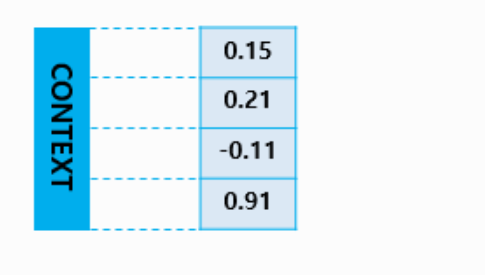

컨텍스트 벡터에 대해서는 뒤에서 다시 언급하겠습니다. 위의 그림에서는 컨텍스트 벡터를 4의 사이즈로 표현하였지만, 실제 현업에서 사용되는 seq2seq 모델에서는 보통 수백 이상의 차원을 갖고있습니다. 인코더와 디코더의 내부를 좀 더 확대해보겠습니다.

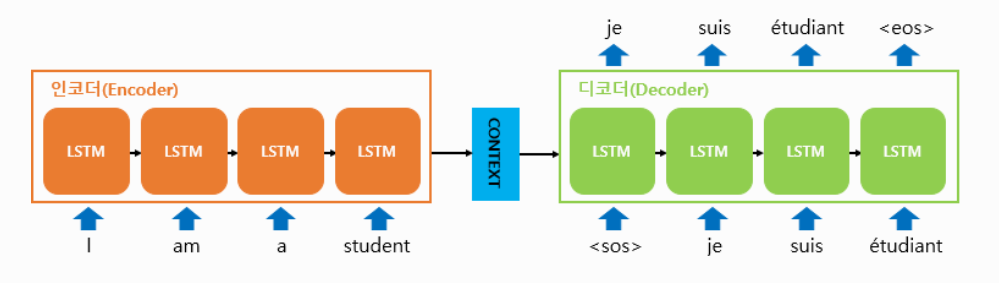

인코더 아키텍처와 디코더 아키텍처의 내부는 사실 두 개의 RNN 아키텍처 입니다. 입력 문장을 받는 RNN 셀을 인코더라고 하고, 출력 문장을 출력하는 RNN 셀을 디코더라고 합니다. 여기서는 인코더의 RNN 셀을 주황색으로, 디코더의 RNN 셀을 초록색으로 표현합니다. 물론, 성능 문제로 인해 실제로는 **바닐라 RNN** 이 아니라 __LSTM 셀__ 또는 __GRU 셀__ 들로 구성됩니다. 우선 인코더를 자세히보면, 입력 문장은 단어 토큰화를 통해서 단어 단위로 쪼개지고 단어 토큰 각각은 RNN 셀의 각 시점의 입력이 됩니다. 인코더 RNN 셀은 모든 단어를 입력받은 뒤에 __인코더 RNN 셀의 마지막 시점의 은닉 상태__ 를 디코더 RNN 셀로 넘겨주는데 이를 __컨텍스트 벡터__ 라고 합니다. 컨텍스트 벡터는 __디코더 RNN 셀의 첫번째 은닉 상태__ 에 사용됩니다.

디코더는 기본적으로 RNNLM(RNN Language Model)입니다. RNNLM의 개념을 기억하고 있다면 좀 더 이해하기 쉽습니다. 디코더는 초기 입력으로 문장의 시작을 의미하는 심볼 `<sos>`가 들어갑니다. 디코더는`<sos>`가 입력되면, 다음에 등장할 확률이 높은 단어를 예측합니다. 첫번째 시점(time step)의 디코더 RNN 셀은 다음에 등장할 단어로 je를 예측하였습니다. 첫번째 시점의 디코더 RNN 셀은 예측된 단어 je를 다음 시점의 RNN 셀의 입력으로 입력합니다. 그리고 두번째 시점의 디코더 RNN 셀은 입력된 단어 je로부터 다시 다음에 올 단어인 suis를 예측하고, 또 다시 이것을 다음 시점의 RNN 셀의 입력으로 보냅니다. 디코더는 이런 식으로 기본적으로 다음에 올 단어를 예측하고, 그 예측한 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다. 이 행위는 문장의 끝을 의미하는 심볼인 `<eos>`가 다음 단어로 예측될 때까지 반복됩니다. __지금 설명하는 것은 테스트 과정__ 동안의 이야기입니다.

seq2seq는 훈련 과정과 테스트 과정(또는 실제 번역기를 사람이 쓸 때)의 작동 방식이 조금 다릅니다. 훈련 과정에서는 디코더에게 인코더가 보낸 컨텍스트 벡터와 실제 정답인 상황인 `<sos>` je suis étudiant를 입력 받았을 때, je suis étudiant `<eos>`가 나와야 된다고 정답을 알려주면서 훈련합니다. 이에 대해서는 뒤에 __교사 강요(teacher forcing)__ 를 설명하면서 재언급하겠습니다. 반면 테스트 과정에서는 앞서 설명한 과정과 같이 디코더는 오직 컨텍스트 벡터와 `<sos>`만을 입력으로 받은 후에 다음에 올 단어를 예측하고, 그 단어를 다음 시점의 RNN 셀의 입력으로 넣는 행위를 반복합니다. 즉, 앞서 설명한 과정과 위의 그림은 테스트 과정에 해당됩니다. 이번에는 입, 출력에 쓰이는 단어 토큰들이 있는 부분을 좀 더 확대해보겠습니다.

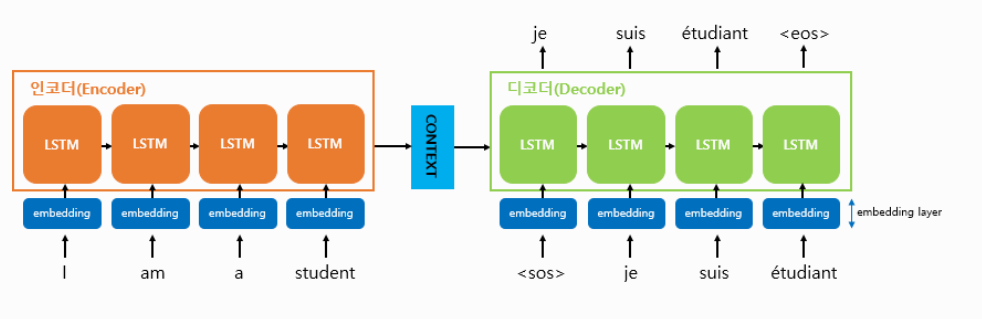

기계는 텍스트보다 숫자를 잘 처리합니다. 자연어 처리에서 텍스트를 벡터로 바꾸는 방법으로 주로 워드 임베딩이 사용된다고 설명한 바 있습니다. 즉, seq2seq에서 사용되는 모든 단어들은 임베딩 벡터로 변환 후 입력으로 사용됩니다. 위 그림은 모든 단어에 대해서 임베딩 과정을 거치게 하는 단계인 임베딩 층(embedding layer)의 모습을 보여줍니다.

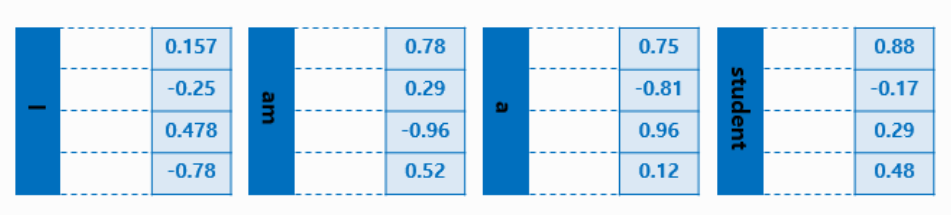

예를 들어 I, am, a, student라는 단어들에 대한 임베딩 벡터는 위와 같은 모습을 가집니다. 여기서는 그림으로 표현하고자 사이즈를 4로 하였지만, 보통 실제 임베딩 벡터는 수백 개의 차원을 가질 수 있습니다. RNN 셀에 대해서 확대해보겠습니다. 이전에 설명하였지만, 하나의 RNN 셀은 각각의 시점(time step)마다 두 개의 입력을 받습니다.

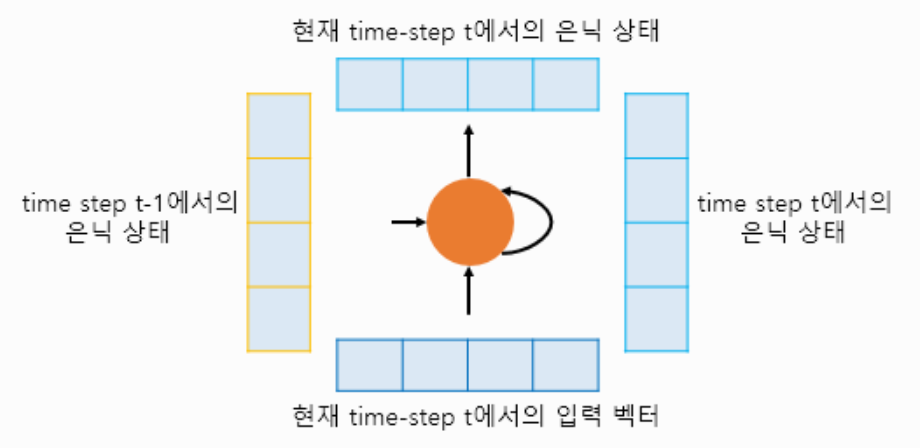

현재 시점(time step)을 t라고 할 때, RNN 셀은 t-1에서의 은닉 상태와 t에서의 입력 벡터를 입력으로 받고, t에서의 은닉 상태를 만듭니다. 이때 t에서의 은닉 상태는 바로 위에 또 다른 은닉층이나 출력층이 존재할 경우에는 위의 층으로 보내거나, 필요없으면 값을 무시할 수 있습니다. 그리고 RNN 셀은 다음 시점에 해당하는 t+1의 RNN 셀의 입력으로 현재 t에서의 은닉 상태를 입력으로 보냅니다.

RNN 챕터에서도 언급했지만, 이런 구조에서 현재 시점 t에서의 은닉 상태는 과거 시점의 동일한 RNN 셀에서의 모든 은닉 상태의 값들의 영향을 누적해서 받아온 값이라고 할 수 있습니다. 그렇기 때문에 앞서 언급했던 컨텍스트 벡터는 사실 인코더에서의 마지막 RNN 셀의 은닉 상태값을 말하는 것이며, 이는 입력 문장의 모든 단어 토큰들의 정보를 요약해서 담고있다고 할 수 있습니다.

디코더는 인코더의 마지막 RNN 셀의 은닉 상태인 컨텍스트 벡터를 첫번째 은닉 상태의 값으로 사용합니다. 디코더의 첫번째 RNN 셀은 이 첫번째 은닉 상태의 값과, 현재 t에서의 입력값인 <sos>로부터, 다음에 등장할 단어를 예측합니다. 그리고 이 예측된 단어는 다음 시점인 t+1 RNN에서의 입력값이 되고, 이 t+1에서의 RNN 또한 이 입력값과 t에서의 은닉 상태로부터 t+1에서의 출력 벡터. 즉, 또 다시 다음에 등장할 단어를 예측하게 될 것입니다. 디코더가 다음에 등장할 단어를 예측하는 부분을 확대해보겠습니다.

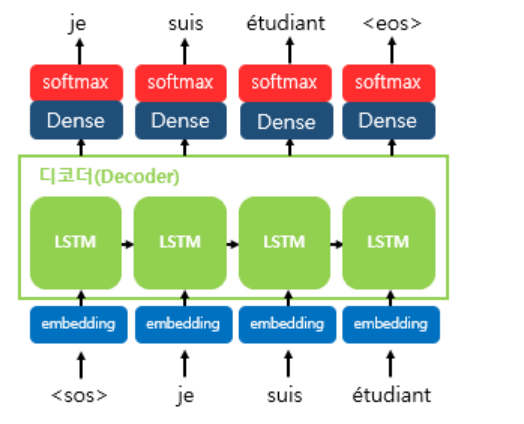

출력 단어로 나올 수 있는 단어들은 다양한 단어들이 있습니다. seq2seq 모델은 선택될 수 있는 모든 단어들로부터 하나의 단어를 골라서 예측해야 합니다. 이를 예측하기 위해서 쓸 수 있는 함수로는 뭐가 있을까요? 바로 소프트맥스 함수입니다. 디코더에서 각 시점(time step)의 RNN 셀에서 출력 벡터가 나오면, 해당 벡터는 소프트맥스 함수를 통해 출력 시퀀스의 각 단어별 확률값을 반환하고, 디코더는 출력 단어를 결정합니다.

지금까지 가장 기본적인 seq2seq에 대해서 배워보았습니다. 사실 seq2seq는 어떻게 구현하느냐에 따라서 충분히 더 복잡해질 수 있습니다. 컨텍스트 벡터를 디코더의 초기 은닉 상태로만 사용할 수도 있고, 거기서 더 나아가 컨텍스트 벡터를 디코더가 단어를 예측하는 매 시점마다 하나의 입력으로 사용할 수도 있으며 거기서 더 나아가면 어텐션 메커니즘이라는 방법을 통해 지금 알고있는 컨텍스트 벡터보다 더욱 문맥을 반영할 수 있는 컨텍스트 벡터를 구하여 매 시점마다 하나의 입력으로 사용할 수도 있습니다. 어텐션 메커니즘에 대해서는 다음 챕터에서 배웁니다.

---
### **2. 문자 레벨 기계 번역기(Character-Level Neural Machine Translation) 구현하기**

seq2seq를 이용해서 기계 번역기를 만들어보겠습니다. 시작하기에 앞서 참고하면 좋은 게시물을 소개합니다. 인터넷에 케라스로 seq2seq를 구현하는 많은 유사 예제들이 나와있지만 대부분은 케라스 개발자 프랑수아 숄레의 블로그의 유명 게시물인 'sequence-to-sequence 10분만에 이해하기'가 원본입니다. 이번 실습 또한 해당 게시물의 예제에 많이 영향받았습니다.

해당 게시물 링크 : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

실제 성능이 좋은 기계 번역기를 구현하려면 정말 방대한 데이터가 필요하므로 여기서는 방금 배운 seq2seq를 실습해보는 수준에서 아주 간단한 기계 번역기를 구축해보겠습니다. 기계 번역기를 훈련시키기 위해서는 훈련 데이터로 병렬 코퍼스(parallel corpus)가 필요합니다. 병렬 코퍼스란, 두 개 이상의 언어가 병렬적으로 구성된 코퍼스를 의미합니다.

다운로드 링크 : http://www.manythings.org/anki

이번 실습에서는 프랑스-영어 병렬 코퍼스인 fra-eng.zip 파일을 사용할 겁니다. 위의 링크에서 해당 파일을 다운받으시면 됩니다. 해당 파일의 압축을 풀면 fra.txt라는 파일이 있는데 이 파일이 이번 실습에서 사용할 파일입니다.

#### **1) 병렬 코퍼스 데이터에 대한 이해와 전처리**
우선 병렬 코퍼스 데이터에 대한 이해를 해보겠습니다. 병렬 데이터라고 하면 앞서 수행한 태깅 작업의 데이터를 생각할 수 있지만, 앞서 수행한 태깅 작업의 병렬 데이터와 seq2seq가 사용하는 병렬 데이터는 성격이 조금 다릅니다. 태깅 작업의 병렬 데이터는 쌍이 되는 모든 데이터가 길이가 같았지만 여기서는 쌍이 된다고 해서 길이가 같지않습니다.

실제 번역기를 생각해보면 구글 번역기에 '나는 학생이다.'라는 토큰의 개수가 2인 문장을 넣었을 때 'I am a student.'라는 토큰의 개수가 4인 문장이 나오는 것과 같은 이치입니다. seq2seq는 기본적으로 입력 시퀀스와 출력 시퀀스의 길이가 다를 수 있다고 가정합니다. 지금은 기계 번역기가 예제지만 seq2seq의 또 다른 유명한 예제 중 하나인 챗봇을 만든다고 가정해보면, 대답의 길이가 질문의 길이와 항상 똑같아야 한다고하면 그 또한 이상합니다.

```Watch me.    Regardez-moi !```

여기서 사용할 fra.txt 데이터는 위와 같이 왼쪽의 영어 문장과 오른쪽의 프랑스어 문장 사이에 탭으로 구분되는 구조가 하나의 샘플입니다. 그리고 이와 같은 형식의 약 16만개의 병렬 문장 샘플을 포함하고 있습니다. 해당 데이터를 읽고 전처리를 진행해보겠습니다. 앞으로의 코드에서 src는 source의 줄임말로 입력 문장을 나타내며, tar는 target의 줄임말로 번역하고자 하는 문장을 나타냅니다.

In [1]:
import pandas as pd
import urllib3
import zipfile
import shutil
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
tf.__version__

'2.19.0'

In [55]:
### # 아래 코드를 실행하면 zip파일이 깨진 상태로 다운로드됨
### # 링크에서 따로 받아서 폴더에 놓고 이후 코드부터 실행 가능

# http = urllib3.PoolManager()
# url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
# with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
#     shutil.copyfileobj(r, out_file)   # 고수준 파일 복사

In [56]:
zipfilename

'h:\\내 드라이브\\0000 강의 로그H\\202412-202506 메디치 3차 컴퓨터비전\\07 자연어처리\\딥러닝을 이용한 자연어 처리 - 수업용\\14. Seq2Seq (NMT)\\fra-eng.zip'

In [57]:
# with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
#     zip_ref.extractall(path)

In [58]:
os.listdir(path)

['save',
 '.ipynb_checkpoints',
 '14_01_seq2seqs.keras',
 '14-01 시퀀스-투-시퀀스(Sequence-to-Sequence, seq2seq).ipynb',
 '_about.txt',
 'fra-eng.zip',
 'fra.txt',
 '14-02 (colab) Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial).ipynb',
 '14_02_seq2seq_tranlation.keras']

In [59]:
path

'h:\\내 드라이브\\0000 강의 로그H\\202412-202506 메디치 3차 컴퓨터비전\\07 자연어처리\\딥러닝을 이용한 자연어 처리 - 수업용\\14. Seq2Seq (NMT)'

In [3]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
lines

,src,tar,lic
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
197458,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
197459,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
197460,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
197461,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [4]:
del lines['lic']
print('전체 샘플의 개수 :', len(lines))

전체 샘플의 개수 : 197463


전체 샘플의 개수는 총 약 19만 7천개입니다.

해당 데이터는 약 19만 2천개의 병렬 문장 샘플로 구성되어있지만 여기서는 간단히 60,000개의 샘플만 가지고 기계 번역기를 구축해보도록 하겠습니다. 우선 전체 데이터 중 60,000개의 샘플만 저장하고 현재 데이터가 어떤 구성이 되었는지 확인해보겠습니다

In [5]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000]     # 6만개만 저장
lines.sample(10)

,src,tar
53470,We still can't see it.,Nous ne pouvons pas encore le voir.
10931,I'll trust you.,Je te ferai confiance.
53415,We know all about you.,Nous savons tout à ton propos.
40117,You are a good cook.,Tu es bon cuisinier.
1115,I saw you.,Je vous ai vus.
38898,Tom is OK with that.,Tom est d'accord avec cela.
4983,I have to go.,Je dois m'en aller.
52584,They hated each other.,Ils se haïssaient l'un l'autre.
54230,You can't pull it off.,On ne peut pas l'arracher.
59294,That was the hard part.,C'était la partie difficile.


위의 테이블은 랜덤으로 선택된 10개의 샘플을 보여줍니다. 번역 문장에 해당되는 프랑스어 데이터는 앞서 배웠듯이 시작을 의미하는 심볼 `<sos>`과 종료를 의미하는 심볼 `<eos>`을 넣어주어야 합니다. 여기서는 `<sos>`와 `<eos>` 대신 `\t`를 시작 심볼, `\n`을 종료 심볼로 간주하여 추가하고 다시 데이터를 출력해보겠습니다.

In [6]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')  # 앞 뒤에 시작, 끝 표시 넣기

In [7]:
lines.tar

0                                  \t Va ! \n
1                               \t Marche. \n
2                            \t En route ! \n
3                               \t Bouge ! \n
4                               \t Salut ! \n
                         ...                 
59995              \t Ce vin est très bon. \n
59996             \t Ça ne fera aucun mal. \n
59997    \t Voilà les choix que vous avez. \n
59998        \t Voilà les choix que tu as. \n
59999                \t Voilà tes options. \n
Name: tar, Length: 60000, dtype: object

In [8]:
lines.sample(10)

,src,tar
32795,Tom refused to eat.,\t Tom a refusé de manger. \n
29029,He banged his knee.,\t Il s'est cogné au genou. \n
17915,Get on your feet.,\t Mettez-vous debout ! \n
43612,I'm kind of confused.,\t Je suis un peu confuse. \n
25346,Let's take a trip.,\t Allons en voyage. \n
4059,Tom'll quit.,\t Tom va arrêter. \n
15709,That can happen.,\t Ça peut arriver. \n
21381,Tom wore goggles.,\t Tom portait des lunettes de protection. \n
40764,But you're not there.,\t Mais tu n'es pas là-bas. \n
10365,I didn't laugh.,\t Je n'ai pas ri. \n


랜덤으로 10개의 샘플을 선택하여 출력하였습니다. 프랑스어 데이터에서 시작 심볼과 종료 심볼이 추가된 것을 볼 수 있습니다. 문자 집합을 생성해보겠습니다. 단어 집합이 아니라 문자 집합이라고 하는 이유는 토큰 단위가 단어가 아니라 문자이기 때문입니다.  
  
* colab으로 실행할 때와 local에서 실행할 때 다른 결과가 나옴 (OS 차이 때문???)  

In [9]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src:  # 1줄씩 읽음
    for char in line:   # 1개의 글자씩 읽음
        src_vocab.add(char)

print(src_vocab)
len(src_vocab)

{'$', 'S', 'Y', 'q', 'z', 'J', 'Z', '%', 'F', '’', 'G', '?', 'A', 'w', ',', 'i', 'I', '0', 'v', '€', 'M', "'", '9', 'X', ':', '3', 'k', ' ', 'e', 'a', 'u', 'h', 'f', '7', 'x', 'B', 'E', '-', 'o', 'U', '4', 'T', 'V', 's', 'H', 'C', '!', 'r', '5', 'P', 'n', 'l', 'd', 'j', 'R', '6', '&', 'D', 'L', 'N', 'c', 'W', 'Q', '8', 't', 'y', '2', '/', 'p', 'm', 'b', 'g', 'é', '.', '"', 'O', 'K', '1'}


78

In [12]:
tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)
print(tar_vocab)
len(tar_vocab)

{'\xa0', '$', 'â', 'S', 'Y', '‘', 'q', 'à', 'ù', 'z', 'J', 'Z', '%', 'F', '’', 'G', '?', 'A', 'î', 'ê', '\u200b', '\t', 'w', ',', 'Ô', 'i', 'I', 'v', '0', 'M', "'", '9', 'X', '\u2009', ':', '3', 'k', ')', 'ô', ' ', 'Ê', 'e', 'a', 'u', 'h', 'f', '\n', '«', '7', 'x', 'B', 'E', '\u202f', 'û', '»', '(', '-', 'o', 'À', 'U', '4', 'T', 'è', 'V', 's', 'H', 'C', '!', 'r', 'Ç', '5', 'P', 'n', 'l', 'ë', 'd', 'œ', 'j', 'R', '6', '&', 'D', 'L', 'N', 'c', 'W', 'Q', '8', 't', 'y', '2', 'p', 'É', 'ï', 'm', 'b', 'g', 'é', '.', '"', 'O', 'K', '1', 'ç'}


104

문자 집합의 크기를 보겠습니다.

In [ ]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :', src_vocab_size)
print('target 문장의 char 집합 :', tar_vocab_size)

source 문장의 char 집합 : 79
target 문장의 char 집합 : 105


영어와 프랑스어는 각각 79개와 105개의 문자가 존재합니다. 이 중에서 **인덱스를 임의로 부여** 하여 일부만 출력해봅시다. 현 상태에서 인덱스를 사용하려고 하면 에러가 납니다. 하지만 정렬하여 순서를 정해준 뒤에 인덱스를 사용하여 출력해주면 됩니다.

In [14]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
print(src_vocab)
print(tar_vocab)

[' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '’', '€']
['\t', '\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'Ô', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '\u200b', '‘', '’', '\u202f']


문자 집합에 문자 단위로 저장된 것을 확인할 수 있습니다. 각 문자에 인덱스를 부여하겠습니다.

In [15]:
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])
print(src_to_index)
print(tar_to_index)

{' ': 1, '!': 2, '"': 3, '$': 4, '%': 5, '&': 6, "'": 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '?': 23, 'A': 24, 'B': 25, 'C': 26, 'D': 27, 'E': 28, 'F': 29, 'G': 30, 'H': 31, 'I': 32, 'J': 33, 'K': 34, 'L': 35, 'M': 36, 'N': 37, 'O': 38, 'P': 39, 'Q': 40, 'R': 41, 'S': 42, 'T': 43, 'U': 44, 'V': 45, 'W': 46, 'X': 47, 'Y': 48, 'Z': 49, 'a': 50, 'b': 51, 'c': 52, 'd': 53, 'e': 54, 'f': 55, 'g': 56, 'h': 57, 'i': 58, 'j': 59, 'k': 60, 'l': 61, 'm': 62, 'n': 63, 'o': 64, 'p': 65, 'q': 66, 'r': 67, 's': 68, 't': 69, 'u': 70, 'v': 71, 'w': 72, 'x': 73, 'y': 74, 'z': 75, 'é': 76, '’': 77, '€': 78}
{'\t': 1, '\n': 2, ' ': 3, '!': 4, '"': 5, '$': 6, '%': 7, '&': 8, "'": 9, '(': 10, ')': 11, ',': 12, '-': 13, '.': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, '?': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 3

인덱스가 부여된 문자 집합으로부터 갖고있는 훈련 데이터에 정수 인코딩을 수행합니다. 우선 인코더의 입력이 될 영어 문장 샘플에 대해서 정수 인코딩을 수행해보고, 5개의 샘플을 출력해봅시다

In [16]:
lines.src

0                            Go.
1                            Go.
2                            Go.
3                            Go.
4                            Hi.
                  ...           
59995    This wine is very good.
59996    This won't hurt at all.
59997    Those are your choices.
59998    Those are your choices.
59999    Those are your choices.
Name: src, Length: 60000, dtype: object

In [17]:
encoder_input = []

# 1개의 문장
for line in lines.src:
    encoded_line = []
    # 각 줄에서 1개의 char
    for char in line:
        # 각 char을 정수로 변환
        encoded_line.append(src_to_index[char])
    encoder_input.append(encoded_line)

# 임의의 위치 프린트 해 보기 
print('source 문장의 정수 인코딩 :', encoder_input[1400:1410])
print(lines.src[1400:1410])

source 문장의 정수 인코딩 : [[42, 54, 54, 1, 50, 51, 64, 71, 54, 10], [42, 54, 54, 1, 51, 54, 61, 64, 72, 10], [42, 54, 54, 1, 51, 54, 61, 64, 72, 10], [42, 54, 58, 75, 54, 1, 57, 58, 62, 2], [42, 54, 58, 75, 54, 1, 57, 58, 62, 2], [42, 54, 58, 75, 54, 1, 57, 58, 62, 2], [42, 54, 58, 75, 54, 1, 57, 58, 62, 2], [42, 54, 67, 58, 64, 70, 68, 61, 74, 23], [42, 54, 67, 58, 64, 70, 68, 61, 74, 23], [42, 54, 67, 58, 64, 70, 68, 61, 74, 23]]
1400    See above.
1401    See below.
1402    See below.
1403    Seize him!
1404    Seize him!
1405    Seize him!
1406    Seize him!
1407    Seriously?
1408    Seriously?
1409    Seriously?
Name: src, dtype: object


정수 인코딩이 수행된 것을 볼 수 있습니다. 디코더의 입력이 될 __프랑스어 데이터__ 에 대해서 정수 인코딩을 수행해보겠습니다.

In [18]:
decoder_input = []
for line in lines.tar:
    encoded_line = []
    for char in line:
        encoded_line.append(tar_to_index[char])
    decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :', decoder_input[:5])
lines.tar[0]

target 문장의 정수 인코딩 : [[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 31, 66, 3, 70, 67, 73, 72, 57, 3, 4, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2]]


'\t Va ! \n'

정상적으로 정수 인코딩이 수행된 것을 볼 수 있습니다. 아직 정수 인코딩을 수행해야 할 데이터가 하나 더 남았습니다. **디코더의 예측값과 비교하기 위한 실제값** 이 필요합니다. 그런데 이 실제값에는 시작 심볼에 해당되는 **`<sos>`가 있을 필요가 없습니다.** 이해가 되지 않는다면 이전 페이지의 그림으로 돌아가 Dense와 Softmax 위에 있는 단어들을 다시 보시기 바랍니다. 그래서 이번에는 정수 인코딩 과정에서 `<sos>`를 제거합니다. 즉, 모든 프랑스어 문장의 맨 앞에 붙어있는 `'\t'`를 제거하도록 합니다.

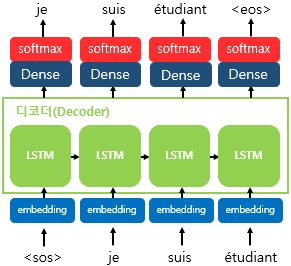

In [34]:
## sos 에 해당하는 '\t'의 인덱스
tar_to_index['\t']

1

In [35]:
lines.tar

0                                  \t Va ! \n
1                               \t Marche. \n
2                            \t En route ! \n
3                               \t Bouge ! \n
4                               \t Salut ! \n
                         ...                 
59995              \t Ce vin est très bon. \n
59996             \t Ça ne fera aucun mal. \n
59997    \t Voilà les choix que vous avez. \n
59998        \t Voilà les choix que tu as. \n
59999                \t Voilà tes options. \n
Name: tar, Length: 60000, dtype: object

In [36]:
decoder_target = []
for line in lines.tar:
    timestep = 0
    encoded_line = []
    for char in line:
        if timestep > 0:   # 첫번째(timestep=0) 문자 '\t'에 해당하는 정수 1 삭제
            encoded_line.append(tar_to_index[char])
        timestep = timestep + 1
    decoder_target.append(encoded_line)
    
print('target 문장 레이블의 정수 인코딩 :', decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 31, 66, 3, 70, 67, 73, 72, 57, 3, 4, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2]]


앞서 먼저 만들었던 디코더의 입력값에 해당되는 decoder_input 데이터와 비교하면 decoder_input에서는 모든 문장의 앞에 붙어있던 **숫자 1이 decoder_target에서는 제거** 된 것을 볼 수 있습니다. `'\t'`가 인덱스가 1이므로 정상적으로 제거된 것입니다. 모든 데이터에 대해서 정수 인덱스로 변경하였으니 패딩 작업을 수행합니다. 패딩을 위해서 영어 문장과 프랑스어 문장 각각에 대해서 가장 길이가 긴 샘플의 길이를 확인합니다.

In [37]:
lines.src

0                            Go.
1                            Go.
2                            Go.
3                            Go.
4                            Hi.
                  ...           
59995    This wine is very good.
59996    This won't hurt at all.
59997    Those are your choices.
59998    Those are your choices.
59999    Those are your choices.
Name: src, Length: 60000, dtype: object

In [38]:
lines.tar

0                                  \t Va ! \n
1                               \t Marche. \n
2                            \t En route ! \n
3                               \t Bouge ! \n
4                               \t Salut ! \n
                         ...                 
59995              \t Ce vin est très bon. \n
59996             \t Ça ne fera aucun mal. \n
59997    \t Voilà les choix que vous avez. \n
59998        \t Voilà les choix que tu as. \n
59999                \t Voilà tes options. \n
Name: tar, Length: 60000, dtype: object

In [39]:
len(lines.tar[0])

8

In [40]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :', max_src_len)
print('target 문장의 최대 길이 :', max_tar_len)

source 문장의 최대 길이 : 23
target 문장의 최대 길이 : 76


각각 23와 76의 길이를 가집니다. 이번 병렬 데이터는 영어와 프랑스어의 길이는 하나의 쌍이라고 하더라도 전부 다르므로 패딩을 할 때도 이 두 개의 데이터의 길이를 전부 동일하게 맞춰줄 필요는 없습니다. **영어 데이터는 영어 샘플들끼리**, **프랑스어는 프랑스어 샘플들끼리** 길이를 맞추어서 패딩하면 됩니다. 여기서는 가장 긴 샘플의 길이에 맞춰서 영어 데이터의 샘플은 전부 길이가 23이 되도록 패딩하고, 프랑스어 데이터의 샘플은 전부 길이가 76이 되도록 **패딩** 합니다.

In [41]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')

In [42]:
encoder_input.shape, encoder_input

((60000, 23, 79),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0,

In [43]:
decoder_input.shape, decoder_input[:1]

((60000, 76, 105),
 array([[[0, 1, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]]]))

In [44]:
decoder_target.shape, decoder_target[:1]

((60000, 76),
 array([[ 3, 48, 53,  3,  4,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]))

모든 값에 대해서 **원-핫 인코딩** 을 수행합니다. **문자 단위 번역기** 므로 워드 임베딩은 별도로 사용되지 않으며, 예측값과의 오차 측정에 사용되는 실제값뿐만 아니라 입력값도 원-핫 벡터를 사용하겠습니다.

In [45]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [46]:
encoder_input.shape, encoder_input

((60000, 23, 79, 2),
 array([[[[1., 0.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[1., 0.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[1., 0.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]],
 
         ...,
 
         [[0., 1.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[0., 1.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]],
 
         [[0., 1.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.]]],
 
 
        [[[1., 0.],
          [1., 0.],
          [1., 0.],
          ...,
          [1., 0.],
          [1., 0.],
          [1., 0.

In [47]:
decoder_input.shape, decoder_target.shape

((60000, 76, 105, 2), (60000, 76, 105))

데이터에 대한 전처리가 모두 끝났습니다. 본격적으로 seq2seq 모델을 설계해보겠습니다.

#### **2) 교사 강요 (Teacher forcing)**

모델을 설계하기 전에 혹시 의아한 점은 없으신가요? 현재 시점의 디코더 셀의 입력은 오직 이전 디코더 셀의 출력을 입력으로 받는다고 설명하였는데 `decoder_input`이 왜 필요할까요?

훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 __RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법__ 을 __교사 강요__ 라고 합니다.

#### **3) seq2seq 기계 번역기 훈련시키기**
seq2seq 모델을 설계하고 교사 강요를 사용하여 훈련시켜보도록 하겠습니다.

In [48]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [49]:
np.__version__

'1.26.4'

In [90]:
#### 아래 블럭 실행하다가 에러 발생
# NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported
# 해결책 : numpy 버전 낮추기
# !pip uninstall numpy
# !conda install numpy=1.19.5 -c conda-forge

In [50]:
src_vocab_size

79

In [51]:
encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)   # 마지막 Hidden State를 디코더에 넘겨주기 위함 

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

In [52]:
encoder_states

[<KerasTensor shape=(None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>]

In [53]:
encoder_inputs

<KerasTensor shape=(None, None, 79), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [54]:
encoder_outputs, state_h, state_c

(<KerasTensor shape=(None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 256), dtype=float32, sparse=False, ragged=False, name=keras_tensor_3>)

인코더를 주목해보면 functional API를 사용한다는 것 외에는 앞서 다른 실습에서 본 LSTM 설계와 크게 다르지는 않습니다. 우선 LSTM의 은닉 상태 크기는 256으로 선택하였습니다. 인코더의 내부 상태를 디코더로 넘겨주어야 하기 때문에 `return_state=True`로 설정합니다. 인코더에 입력을 넣으면 내부 상태를 리턴합니다.

LSTM에서 `state_h`, `state_c`를 리턴받는데, 이는 각각 LSTM을 설명할 때 언급하였던 배운 은닉 상태와 셀 상태에 해당됩니다. 앞서 이론을 설명할 때는 셀 상태는 설명에서 생략하고 은닉 상태만 언급하였으나 사실 LSTM은 은닉 상태와 셀 상태라는 두 가지 상태를 가진다는 사실을 기억해야 합니다. 갑자기 어려워진 게 아닙니다. 단지 은닉 상태만 전달하는 게 아니라 **은닉 상태와 셀 상태 두 가지를 전달** 한다고 생각하면 됩니다. 이 두 가지 상태를 `encoder_states`에 저장합니다. `encoder_states`를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달합니다. 이것이 앞서 배운 **컨텍스트 벡터** 입니다.

In [55]:
decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
decoder_outputs

<KerasTensor shape=(None, None, 105), dtype=float32, sparse=False, ragged=False, name=keras_tensor_8>

In [58]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 79)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    344,064 │ input_layer[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    370,688 │ input_layer_1[0]… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 105) │     26,985 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 741,737 (2.83 MB)

 Trainable params: 741,737 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('ch_seq_to_seq_best_model.keras', monitor='val_loss', 
                                   save_best_only=True, mode='min')
history = model.fit([encoder_input, decoder_input], decoder_target, 
                    epochs=25, batch_size=16, 
                    validation_split=0.2, 
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 244s 80ms/step - accuracy: 0.7807 - loss: 0.8351 - val_accuracy: 0.8097 - val_loss: 0.6333
Epoch 2/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 234s 78ms/step - accuracy: 0.8620 - loss: 0.4641 - val_accuracy: 0.8439 - val_loss: 0.5252
Epoch 3/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 246s 82ms/step - accuracy: 0.8832 - loss: 0.3914 - val_accuracy: 0.8589 - val_loss: 0.4739
Epoch 4/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 261s 87ms/step - accuracy: 0.8940 - loss: 0.3521 - val_accuracy: 0.8680 - val_loss: 0.4422
Epoch 5/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 254s 85ms/step - accuracy: 0.9017 - loss: 0.3247 - val_accuracy: 0.8738 - val_loss: 0.4212
Epoch 6/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 260s 87ms/step - accuracy: 0.9072 - loss: 0.3063 - val_accuracy: 0.8785 - val_loss: 0.4058
Epoch 7/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 271s 90ms/step - accuracy: 0.9117 - loss: 0.2907 - val_accuracy: 0.8803 - val_loss: 0.3988
Epoch 8/25
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 267s 89ms/step - accuracy: 

디코더는 **인코더의 마지막 은닉 상태를 초기 은닉 상태로 사용** 합니다. 위에서 initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다. 또한 동일하게 디코더의 은닉 상태 크기도 256으로 주었습니다. **디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다.** 그 후 출력층에 프랑스어의 단어 집합의 크기만큼 뉴런을 배치한 후 소프트맥스 함수를 사용하여 실제값과의 오차를 구합니다.

In [ ]:
# %%time
# # Epoch 14/40  14번째 epoch가 가장 낮은 val_loss (GPU)
# # 750/750 [==============================] - 139s 186ms/step - loss: 0.2120 - val_loss: 0.3517
# # Epoch 40/40
# # 750/750 [==============================] - 256s 342ms/step - loss: 0.1343 - val_loss: 0.4017
# # CPU times: total: 7h 4min 54s
# # Wall time: 1h 36min 33s
# model.fit(x=[encoder_input, decoder_input], y=decoder_target, 
#           batch_size=64, 
#           epochs=25, 
#           validation_split=0.2)

Epoch 1/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 243s 312ms/step - loss: 1.1678 - val_loss: 0.8096
Epoch 2/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 235s 313ms/step - loss: 0.6155 - val_loss: 0.6969
Epoch 3/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 245s 326ms/step - loss: 0.5341 - val_loss: 0.6303
Epoch 4/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 252s 313ms/step - loss: 0.4827 - val_loss: 0.5820
Epoch 5/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 261s 312ms/step - loss: 0.4417 - val_loss: 0.5491
Epoch 6/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 220s 293ms/step - loss: 0.4108 - val_loss: 0.5154
Epoch 7/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 177s 236ms/step - loss: 0.3874 - val_loss: 0.4914
Epoch 8/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 179s 238ms/step - loss: 0.3688 - val_loss: 0.4738
Epoch 9/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 180s 240ms/step - loss: 0.3540 - val_loss: 0.4616
Epoch 10/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 177s 206ms/step - loss: 0.3421 - val_loss: 0.4523
Epoch 11/25
750/750 ━━━━━━━━━━━━━━━━━━━━ 198s 200ms/step - loss: 0.3324 - val_loss: 0.4410
Epoch 12

입력으로는 인코더 입력과 디코더 입력이 들어가고, 디코더의 실제값인 decoder_target도 필요합니다. 배치 크기는 64로 하였으며 총 40 에포크를 학습합니다. 위에서 설정한 은닉 상태의 크기와 에포크 수는 실제로는 훈련 데이터에 과적합 상태를 불러옵니다. 중간부터 검증 데이터에 대한 오차인 val_loss의 값이 올라가는데, 사실 이번 실습에서는 주어진 데이터의 양과 태스크의 특성으로 인해 훈련 과정에서 훈련 데이터의 정확도와 과적합 방지라는 두 마리 토끼를 동시에 잡기에는 쉽지 않습니다. 여기서는 우선 seq2seq의 메커니즘과 짧은 문장과 긴 문장에 대한 성능 차이에 대한 확인을 중점으로 두고 훈련 데이터에 과적합 된 상태로 동작 단계로 넘어갑니다.

#### **4) seq2seq 기계 번역기 동작시키기**
앞서 seq2seq는 훈련할 때와 동작할 때의 방식이 다르다고 언급한 바 있습니다. 이번에는 입력한 문장에 대해서 기계 번역을 하도록 모델을 조정하고 동작시켜보도록 하겠습니다.

전체적인 번역 동작 단계를 정리하면 아래와 같습니다.
1. 번역하고자 하는 입력 문장이 인코더에 들어가서 은닉 상태와 셀 상태를 얻습니다.
2. 상태와 `<sos>`에 해당하는 `\t`를 디코더로 보냅니다.
3. 디코더가 `<eos>`에 해당하는 `\n`이 나올 때까지 다음 문자를 예측하는 행동을 반복합니다.

In [47]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)

In [48]:
encoder_inputs

<KerasTensor: shape=(None, None, 79) dtype=float32 (created by layer 'input_1')>

In [49]:
encoder_states

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>]

In [54]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 79)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             344064    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 344,064
Trainable params: 344,064
Non-trainable params: 0
_________________________________________________________________


우선 인코더를 정의합니다. encoder_inputs와 encoder_states는 훈련 과정에서 이미 정의한 것들을 재사용하는 것입니다. 디코더를 설계해보겠습니다.

In [50]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용.
# 뒤의 함수 decode_sequence()에 동작을 구현 예정
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

In [51]:
decoder_outputs, state_h, state_c

(<KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>)

In [52]:
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않음.
decoder_states = [state_h, state_c]
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)

In [53]:
decoder_states, decoder_outputs, decoder_model

([<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>,
  <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_1')>],
 <KerasTensor: shape=(None, None, 105) dtype=float32 (created by layer 'dense')>,
 <keras.engine.functional.Functional at 0x7f346769c790>)

In [ ]:
index_to_src = dict((i, char) for char, i in src_to_index.items())  # 영어 단어사전 
index_to_tar = dict((i, char) for char, i in tar_to_index.items())  # 프랑스어 단어사전 

In [56]:
print(len(index_to_src), index_to_src)

78 {1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: '?', 24: 'A', 25: 'B', 26: 'C', 27: 'D', 28: 'E', 29: 'F', 30: 'G', 31: 'H', 32: 'I', 33: 'J', 34: 'K', 35: 'L', 36: 'M', 37: 'N', 38: 'O', 39: 'P', 40: 'Q', 41: 'R', 42: 'S', 43: 'T', 44: 'U', 45: 'V', 46: 'W', 47: 'X', 48: 'Y', 49: 'Z', 50: 'a', 51: 'b', 52: 'c', 53: 'd', 54: 'e', 55: 'f', 56: 'g', 57: 'h', 58: 'i', 59: 'j', 60: 'k', 61: 'l', 62: 'm', 63: 'n', 64: 'o', 65: 'p', 66: 'q', 67: 'r', 68: 's', 69: 't', 70: 'u', 71: 'v', 72: 'w', 73: 'x', 74: 'y', 75: 'z', 76: 'é', 77: '’', 78: '€'}


In [57]:
print(len(index_to_tar), index_to_tar)

104 {1: '\t', 2: '\n', 3: ' ', 4: '!', 5: '"', 6: '$', 7: '%', 8: '&', 9: "'", 10: '(', 11: ')', 12: ',', 13: '-', 14: '.', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: '?', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'E', 32: 'F', 33: 'G', 34: 'H', 35: 'I', 36: 'J', 37: 'K', 38: 'L', 39: 'M', 40: 'N', 41: 'O', 42: 'P', 43: 'Q', 44: 'R', 45: 'S', 46: 'T', 47: 'U', 48: 'V', 49: 'W', 50: 'X', 51: 'Y', 52: 'Z', 53: 'a', 54: 'b', 55: 'c', 56: 'd', 57: 'e', 58: 'f', 59: 'g', 60: 'h', 61: 'i', 62: 'j', 63: 'k', 64: 'l', 65: 'm', 66: 'n', 67: 'o', 68: 'p', 69: 'q', 70: 'r', 71: 's', 72: 't', 73: 'u', 74: 'v', 75: 'w', 76: 'x', 77: 'y', 78: 'z', 79: '\xa0', 80: '«', 81: '»', 82: 'À', 83: 'Ç', 84: 'É', 85: 'Ê', 86: 'Ô', 87: 'à', 88: 'â', 89: 'ç', 90: 'è', 91: 'é', 92: 'ê', 93: 'ë', 94: 'î', 95: 'ï', 96: 'ô', 97: 'ù', 98: 'û', 99: 'œ', 100: '\u2009', 101: '\u200b', 102: '‘', 103: '’', 104: '\u202f'}


단어로부터 인덱스를 얻는 것이 아니라 인덱스로부터 단어를 얻을 수 있는 index_to_src와 index_to_tar를 만들었습니다.

In [58]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab_size))
    target_seq[0, 0, tar_to_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
            len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, tar_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [65]:
N = 12345
encoder_input[[N]].shape, encoder_input[[N]]

((1, 23, 79), array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32))

In [66]:
lines.src[N]

'Tom was skiing.'

In [67]:
decode_sequence(encoder_input[[N]])

1/1 [==============================] - 0s 16ms/step


" Tom s'en souvient. \n"

In [59]:
for seq_index in [3,50,100,300,1001, 1234, 1345, 2032]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: Go.
정답 문장: Bouge ! 
번역 문장: Décampe ! 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Hello!
정답 문장: Bonjour ! 
번역 문장: Bonjour ! 
1/1 [==============================] - 0s 14ms/step
-----------------------------------
입력 문장: Got it?
정답 문장: T'as capté ? 
번역 문장: Es amour ! 
1/1 [==============================] - 0s 15ms/step
-----------------------------------
입력 문장: Hang on.
정답 문장: Tiens bon ! 
번역 문장: Accroche-toi ! 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Here's $5.
정답 문장: Voilà cinq dollars. 
번역 문장: Voilà le compage. 
1/1 [==============================] - 0s 14ms/step
-----------------------------------
입력 문장: Is it far?
정답 문장: Est-ce loin ? 
번역 문장: Est-ce de notre ? 
1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: Lie still.
정답 문장: Restez allon

In [ ]:
for seq_index in [111, 211, 311, 411, 511, 611]: # 입력 문장의 인덱스
    input_seq = encoder_input[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.src[seq_index])
    print('정답 문장:', lines.tar[seq_index][2:len(lines.tar[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역 문장:', decoded_sentence[1:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: I left.
정답 문장: Je suis partie. 
번역 문장: Je suis parti. 
-----------------------------------
입력 문장: Come on!
정답 문장: Allez ! 
번역 문장: Encortez ! 
-----------------------------------
입력 문장: Help us.
정답 문장: Aide-nous ! 
번역 문장: Aide-nous ! 
-----------------------------------
입력 문장: Take it.
정답 문장: Prenez-le ! 
번역 문장: Prenez-le. 
-----------------------------------
입력 문장: Get away.
정답 문장: Pars. 
번역 문장: Dégage ! 
-----------------------------------
입력 문장: I failed.
정답 문장: J'ai échoué. 
번역 문장: J'ai été blessé. 


지금까지 문자 단위의 seq2seq를 구현하였습니다. 다음 실습에서는 이번 실습에서 배운 내용을 바탕으로 문자 단위에서 단어 단위로 확장해서 기계 번역기를 구현해보겠습니다.